# Pharmacophore visualizations


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import copy
from glob import glob
import collections
from collections import Counter
from pathlib import Path
import operator
import time
import math
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets, cluster

from rdkit.Chem import PandasTools
from rdkit import RDConfig, Chem, Geometry, DistanceGeometry
from rdkit.Chem import (
    ChemicalFeatures,
    rdDistGeom,
    Draw,
    rdMolTransforms,
    AllChem,
)

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdmolfiles
from rdkit.Chem.Draw import DrawingOptions
from rdkit.Chem.Pharm3D import Pharmacophore, EmbedLib
from rdkit.Numerics import rdAlignment
import nglview as nv
import py3Dmol
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import AllChem
from rdkit.Chem import rdBase
from rdkit.Chem import rdMolAlign
from rdkit.Chem import rdMolDescriptors
p = AllChem.ETKDGv2()
p.verbose = True
from rdkit import Chem, DataStructs, RDConfig
from rdkit.Chem import AllChem
from rdkit.Chem.Pharm2D import Gobbi_Pharm2D, Generate

## PDB files with ligands

5rl9_B_ligand.pdb

5rli_B_ligand.pdb

5rlj_B_ligand.pdb

5rlr_B_ligand.pdb

In [3]:
ligands = []
ids = []
for path in glob("./*.pdb", recursive=True):
    ids.append(path[2:8])
    ligands.append(rdmolfiles.MolFromPDBFile(path))

In [4]:
ids

['5rl9_B', '5rli_B', '5rlj_B', '5rlr_B', '5rlw_B']

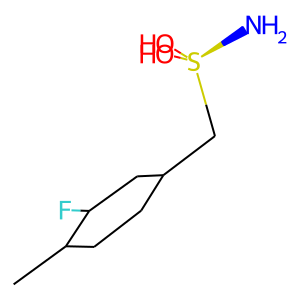

In [5]:
Draw.MolToImage(ligands[0])

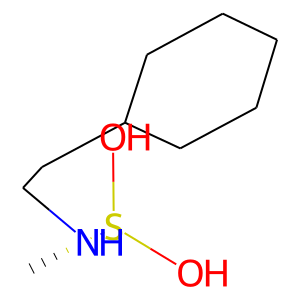

In [6]:
Draw.MolToImage(ligands[1])

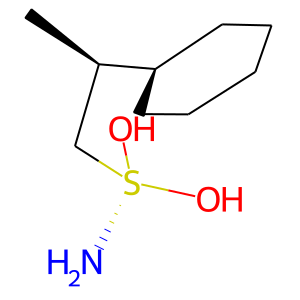

In [7]:
Draw.MolToImage(ligands[2])

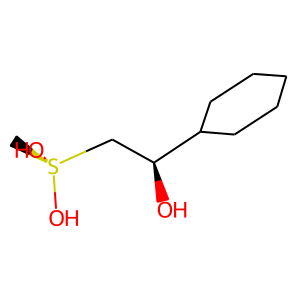

In [8]:
Draw.MolToImage(ligands[3])

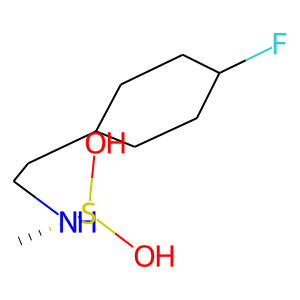

In [9]:
Draw.MolToImage(ligands[4])

In [12]:
import nglview as nv
from nglview.show import StringIO
import time
 
def show_ligands(molecules):
    view = nv.NGLWidget()
    for molecule in molecules:
        temp_mol = StringIO(Chem.MolToPDBBlock(molecule))
        component = view.add_component(temp_mol, ext='pdb')
        time.sleep(0.1)
        component.clear()
        component.add_ball_and_stick(multipleBond=True)
    return view

#Wizualizacja dwóch pierwszych cżasteczek
view = show_ligands(ligands[:2])
view.render_image(trim=True, factor=2, transparent=True)
view

NGLWidget()

In [13]:
def get_mols_descriptors(mols, ids):
    
#     mols = [Chem.MolFromSmiles(m) for m in smiles_list]
    mols_desc = {}
    mols_desc["Smiles"] = ids

    #descriptors
    from rdkit.Chem import Descriptors

    logP = [Descriptors.MolLogP(m) for m in mols]
    mols_desc["LogP"] = logP

    mol_wt = [Descriptors.MolWt(m) for m in mols]
    mols_desc["Mol_Wt"] = mol_wt

    #more descriptors
    from rdkit.Chem import rdMolDescriptors

    #H-bond acceptors
    HBA = [rdMolDescriptors.CalcNumHBA(m) for m in mols]
    mols_desc["HBA"] = HBA

    #H-bond donors
    HBD = [rdMolDescriptors.CalcNumHBD(m) for m in mols]
    mols_desc["HBD"] = HBD

    #analiza fragmentóww molekularnych

    aromatic_carbocycles = [rdMolDescriptors.CalcNumAromaticCarbocycles(m) for m in mols]
    mols_desc["aromatic_carbocycles"] = aromatic_carbocycles

    aromatic_heterocycles = [rdMolDescriptors.CalcNumAromaticHeterocycles(m) for m in mols]
    mols_desc["aromatic_heterocycles"] = aromatic_heterocycles

    aromatic_rings = [rdMolDescriptors.CalcNumAromaticRings(m) for m in mols]
    mols_desc["aromatic_rings"] = aromatic_rings

    aliphatic_carbocycles = [rdMolDescriptors.CalcNumAliphaticCarbocycles(m) for m in mols]
    mols_desc["aliphatic_carbocycles"] = aliphatic_carbocycles

    aliphatic_heterocycles = [rdMolDescriptors.CalcNumAliphaticHeterocycles(m) for m in mols]
    mols_desc["aliphatic_heterocycles"] = aliphatic_heterocycles

    aliphatic_rings = [rdMolDescriptors.CalcNumAliphaticRings(m) for m in mols]
    mols_desc["aliphatic_rings"]  = aliphatic_rings

    mols_desc = pd.DataFrame.from_dict(mols_desc)
    return mols_desc

get_mols_descriptors(ligands, ids)

,Smiles,LogP,Mol_Wt,HBA,HBD,aromatic_carbocycles,aromatic_heterocycles,aromatic_rings,aliphatic_carbocycles,aliphatic_heterocycles,aliphatic_rings
0,5rl9_B,2.3850,211.302,3,3,0,0,0,1,0,1
1,5rli_B,2.8418,207.339,3,3,0,0,0,1,0,1
2,5rlj_B,2.8271,207.339,3,3,0,0,0,1,0,1
3,5rlr_B,2.3080,208.323,3,3,0,0,0,1,0,1
4,5rlw_B,2.7898,225.329,3,3,0,0,0,1,0,1


In [14]:
mol_files = [path for path in glob("./*_ligand.pdb")]
print(mol_files)

['.\\5rl9_B_ligand.pdb', '.\\5rli_B_ligand.pdb', '.\\5rlj_B_ligand.pdb', '.\\5rlr_B_ligand.pdb', '.\\5rlw_B_ligand.pdb']


In [15]:
# NBVAL_CHECK_OUTPUT
molecules = []
smiles = []
for mol_file in mol_files:
    molecule = rdmolfiles.MolFromPDBFile(mol_file, removeHs=False)
    if molecule is None:
        print(mol_file, "Could not be read")
    else:
        Chem.SanitizeMol(molecule)
        smi = Chem.MolToSmiles(molecule)
        smiles.append(smi)
        print(smi)
        molecules.append(molecule)
print(f"Number of molecules: {len(molecules)}")

CC1CCC(CS(N)(O)O)CC1F
CS(O)(O)NCCC1CCCCC1
C[C@H](CS(N)(O)O)C1CCCCC1
CS(O)(O)C[C@H](O)C1CCCCC1
CS(O)(O)NCCC1CCC(F)CC1
Number of molecules: 5


## Assigning bond orders
We use the RDKit function `AssignBondOrdersFromTemplate`, which assigns bonds to a molecule based on a reference molecule, e.g. in our case based on the SMILES pattern of the molecule.

In [18]:
# Load SMILES for PDB ligand structures
lig_smiles = pd.read_csv("Ligands_from_PDB_structures.csv")
lig_smiles

,Structure_id,Ligand_name,Smiles
0,5rl7_A,VVD,CC(=O)Nc1ccc(c(c1)C(=O)O)F
1,5rl9_B,UR7,Cc1ccc(cc1F)CS(=O)(=O)N
2,5rlj_B,VW4,C[C@H](CS(=O)(=O)N)c1ccccc1
3,5rln_A,NZG,CC(=O)Nc1cc(ccc1F)C(=O)O
4,5rlo_B,UQS,c1ccc(c(c1)CNc2c[nH]nc2)F
5,5rlw_B,S9S,CS(=O)(=O)NCCc1ccc(cc1)F
6,5rli_B,JFM,CS(=O)(=O)NCCc1ccccc1
7,5rlr_B,VWD,CS(=O)(=O)C[C@@H](c1ccccc1)O
8,5rls_A,VWG,c1ccc2c(c1)ccc(n2)C(=O)NO
9,5rm7_B,N0E,c1ccc(cc1)CCC(=O)Nc2ccc(cc2)O


In [20]:
# Get SMILES in the same order as in pdb_ids
ligand_smiles = [
    lig_smiles[lig_smiles["Structure_id"] == pdb_id]["Smiles"].values[0] for pdb_id in ids
]
print(ligand_smiles)

['Cc1ccc(cc1F)CS(=O)(=O)N', 'CS(=O)(=O)NCCc1ccccc1', 'C[C@H](CS(=O)(=O)N)c1ccccc1', 'CS(=O)(=O)C[C@@H](c1ccccc1)O', 'CS(=O)(=O)NCCc1ccc(cc1)F']


In [21]:
# Generate RDKit Mol object from SMILES
reference_molecules = [Chem.MolFromSmiles(smiles) for smiles in ligand_smiles]

# Assign bond orders to molecules based on SMILES patterns of reference molecules
molecules = [
    AllChem.AssignBondOrdersFromTemplate(reference_molecule, molecule)
    for reference_molecule, molecule in zip(reference_molecules, molecules)
]

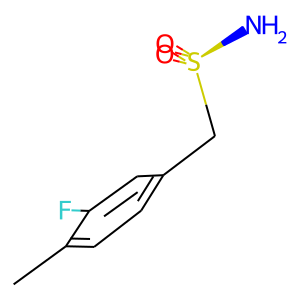

In [22]:
Draw.MolToImage(molecules[0])

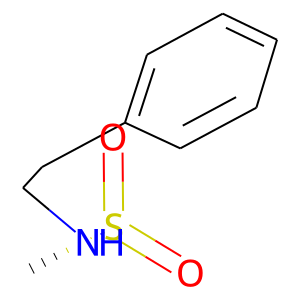

In [23]:
Draw.MolToImage(molecules[1])

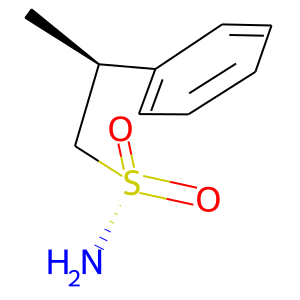

In [24]:
Draw.MolToImage(molecules[2])

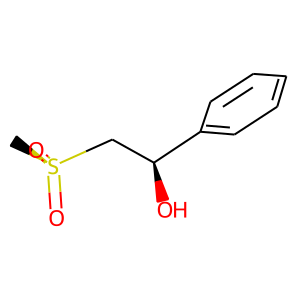

In [25]:
Draw.MolToImage(molecules[3])

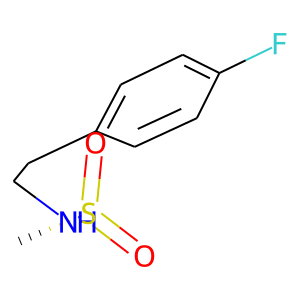

In [26]:
Draw.MolToImage(molecules[4])

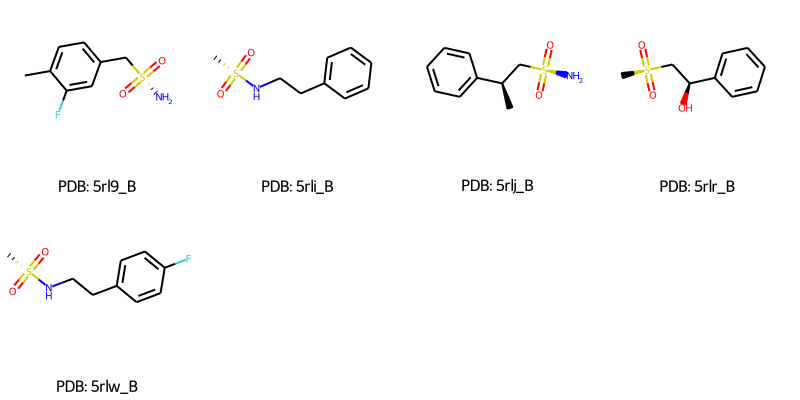

In [30]:
molecules_2d = []
for molecule in molecules:
    tmp = Chem.Mol(molecule)
    AllChem.Compute2DCoords(tmp)
    molecules_2d.append(tmp)
Draw.MolsToGridImage(
    molecules_2d,
    molsPerRow=4,
    legends=[f"PDB: {pdb_id}" for pdb_id in ids],
)

## 3D alignment


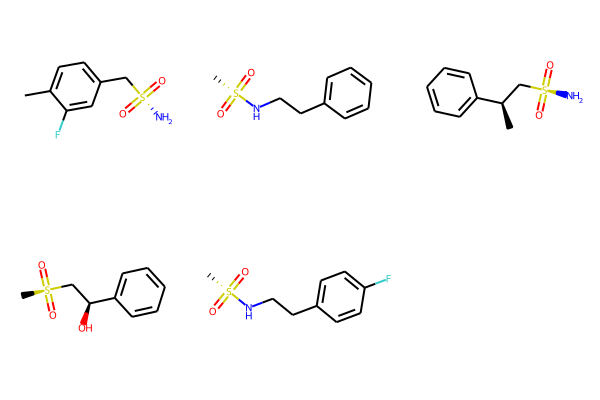

In [31]:
mols = molecules_2d
for mol in mols:
    mol.RemoveAllConformers()
hmols_1 = [Chem.AddHs(m) for m in mols]
hmols_2 = copy.deepcopy(hmols_1)
# Generate 100 conformers per each molecule
for mol in hmols_1:
    # AllChem.EmbedMolecule(mol, p, )
    AllChem.EmbedMultipleConfs(mol, 100, p)

for mol in hmols_2:
    # AllChem.EmbedMolecule(mol, p, )
    AllChem.EmbedMultipleConfs(mol, 100, p)
Draw.MolsToGridImage(mols)

In [32]:
crippen_contribs = [rdMolDescriptors._CalcCrippenContribs(mol) for mol in hmols_1]
crippen_ref_contrib = crippen_contribs[0]
crippen_prob_contribs = crippen_contribs[1:]
ref_mol1 = hmols_1[0]
prob_mols_1 = hmols_1[1:]

mmff_params = [AllChem.MMFFGetMoleculeProperties(mol) for mol in hmols_2]
mmff_ref_param = mmff_params[0]
mmff_prob_params = mmff_params[1:]
ref_mol2 = hmols_2[0]
prob_mols_2 = hmols_2[1:]

print(ref_mol1.GetNumConformers())

100


In [33]:
p_crippen = py3Dmol.view(width=600, height=400)
p_crippen.addModel(Chem.MolToMolBlock(ref_mol1), 'sdf')
crippen_score = []
for idx, mol in enumerate(prob_mols_1):
    tempscore = []
    for cid in range(100):
        crippenO3A = rdMolAlign.GetCrippenO3A(mol, ref_mol1, crippen_prob_contribs[idx], crippen_ref_contrib, cid, 0)
        crippenO3A.Align()
        tempscore.append(crippenO3A.Score())
    best = np.argmax(tempscore)
    p_crippen.addModel(Chem.MolToMolBlock(mol, confId=int(best)), 'sdf')
    crippen_score.append(tempscore[best])
p_crippen.setStyle({'stick':{}})
p_crippen.render()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [34]:
p_O3A = py3Dmol.view(width=600, height=400)
p_O3A.addModel(Chem.MolToMolBlock(ref_mol2), 'sdf')
pyO3A_score = []
for idx, mol in enumerate(prob_mols_2):
    tempscore = []
    for cid in range(100):
        pyO3A = rdMolAlign.GetO3A(mol, ref_mol2, mmff_prob_params[idx], mmff_ref_param, cid, 0)
        pyO3A.Align()
        tempscore.append(pyO3A.Score())
    best = np.argmax(tempscore)
    p_O3A.addModel(Chem.MolToMolBlock(mol, confId=int(best)), 'sdf')
    pyO3A_score.append(tempscore[best])
p_O3A.setStyle({'stick':{'colorscheme':'cyanCarbon'}})
p_O3A.render()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## 3D pharmacophore fingerprints

In [191]:
# factory = Gobbi_Pharm2D.factory
# #calc 3d p4 fp
# fp = Generate.Generate2DFingerPrint(molecules[0], factory, dMat = Chem.Get3DDistanceMatrix(molecules[0]))
# # dMat option is Key!

In [192]:
# fp1 = Generate.Generate2DFingerPrint(molecules[0], factory, dMat = Chem.Get3DDistanceMatrix(molecules[0]))
# # fp2 = Generate.Generate2DFingerPrint(molecules[0], factory, dMat = Chem.Get3DDistanceMatrix(molecules[0])

In [193]:
# ph = Chem.Pharm3D.Pharmacophore.ExplicitPharmacophore(molecules)
# print(ph)

# Extract pharmacophore features

In [35]:
import os
from rdkit.Chem import AllChem
from rdkit import RDConfig
 
fdefName = os.path.join(RDConfig.RDDataDir,'BaseFeatures.fdef')
pharmacophore_features = AllChem.BuildFeatureFactory(fdefName)
 
list(pharmacophore_features.GetFeatureDefs().keys())

['Donor.SingleAtomDonor',
 'Acceptor.SingleAtomAcceptor',
 'NegIonizable.AcidicGroup',
 'PosIonizable.BasicGroup',
 'PosIonizable.PosN',
 'PosIonizable.Imidazole',
 'PosIonizable.Guanidine',
 'ZnBinder.ZnBinder1',
 'ZnBinder.ZnBinder2',
 'ZnBinder.ZnBinder3',
 'ZnBinder.ZnBinder4',
 'ZnBinder.ZnBinder5',
 'ZnBinder.ZnBinder6',
 'Aromatic.Arom4',
 'Aromatic.Arom5',
 'Aromatic.Arom6',
 'Aromatic.Arom7',
 'Aromatic.Arom8',
 'Hydrophobe.ThreeWayAttach',
 'Hydrophobe.ChainTwoWayAttach',
 'LumpedHydrophobe.Nitro2',
 'LumpedHydrophobe.RH6_6',
 'LumpedHydrophobe.RH5_5',
 'LumpedHydrophobe.RH4_4',
 'LumpedHydrophobe.RH3_3',
 'LumpedHydrophobe.tButyl',
 'LumpedHydrophobe.iPropyl']

In [43]:
for name, mol in zip(ids, molecules):
    # pharmacophore features for molecules
    print(f"PDB ID: {name}")
    features = pharmacophore_features.GetFeaturesForMol(mol)
    #otrzymanie typów cech używanych do konstrukcji farmakoforu
    from rdkit.Chem import rdChemicalFeatures
    a = 0
    for feat in features:
        a+=1
        print("{}: {}".format(a, feat.GetFamily()))

PDB ID: 5rl9_B
1: Donor
2: Acceptor
3: Acceptor
4: Acceptor
5: Aromatic
6: Hydrophobe
7: Hydrophobe
8: Hydrophobe
9: LumpedHydrophobe
PDB ID: 5rli_B
1: Donor
2: Acceptor
3: Acceptor
4: Aromatic
5: Hydrophobe
6: Hydrophobe
7: LumpedHydrophobe
PDB ID: 5rlj_B
1: Donor
2: Acceptor
3: Acceptor
4: Aromatic
5: Hydrophobe
6: Hydrophobe
7: Hydrophobe
8: LumpedHydrophobe
PDB ID: 5rlr_B
1: Donor
2: Acceptor
3: Acceptor
4: Acceptor
5: Aromatic
6: Hydrophobe
7: Hydrophobe
8: LumpedHydrophobe
PDB ID: 5rlw_B
1: Donor
2: Acceptor
3: Acceptor
4: Acceptor
5: Aromatic
6: Hydrophobe
7: Hydrophobe
8: LumpedHydrophobe


## Count pharmacophore features in ligands

In [44]:
def count_family(mols, ids):
#     mols = [Chem.MolFromSmiles(s) for s in smiles_list]
    features = [pharmacophore_features.GetFeaturesForMol(m) for m in mols]
    
    Donor = []
    Acceptor = []
    Aromatic = []
    Hydrophobe = []
    
    for i in range(len(features)):
        families = []
        for feat in features[i]:
            families.append(feat.GetFamily())
        Donor.append(families.count("Donor"))
        Acceptor.append(families.count("Acceptor"))
        Aromatic.append(families.count("Aromatic"))
        Hydrophobe.append(families.count("Hydrophobe"))
        
#     d = {"smiles": smiles_list, "Donor": Donor, "Acceptor": Acceptor, "Aromatic": Aromatic, "Hydrophobe": Hydrophobe}  
    d = {"IDs": ids, "Donor": Donor, "Acceptor": Acceptor, "Aromatic": Aromatic, "Hydrophobe": Hydrophobe}   

    df = pd.DataFrame(d)
    
    return df

count_family(molecules, ids)

,IDs,Donor,Acceptor,Aromatic,Hydrophobe
0,5rl9_B,1,3,1,3
1,5rli_B,1,2,1,2
2,5rlj_B,1,2,1,3
3,5rlr_B,1,3,1,2
4,5rlw_B,1,3,1,2


# Feature visualization
Generate 3D conformation and aligment 3D using reference structure. Finding maximal common substructure where atryctures align.

In [45]:
from rdkit.Chem import rdFMCS

def generate_conformers(mol, numConformers):
    AllChem.EmbedMolecule(mol)
    AllChem.MMFFOptimizeMolecule(mol)    
    cids=AllChem.EmbedMultipleConfs(mol, numConfs=numConformers, maxAttempts=50, pruneRmsThresh=0.5)
    for cid in cids: 
        AllChem.MMFFOptimizeMolecule(mol,confId=cid)
    return cids
 
mols = molecules 

refMol = mols[2]
conformers_num = 1000
for mol in mols[:2]+mols[3:]:
    refCids = generate_conformers(refMol, 1)
    mcs = rdFMCS.FindMCS([refMol,mol])        
 
    if mcs.numAtoms > 0:
        core = Chem.MolFromSmarts(mcs.smartsString)
        print(Chem.MolToSmiles(mol))
 
        refMatch = refMol.GetSubstructMatch(core) 
        match = mol.GetSubstructMatch(core)           
        cids = generate_conformers(mol, conformers_num)            
 
        minRmsd = 100         
 
        for cid in cids:
            rmsd = AllChem.AlignMol(refMol, mol, prbCid=refCids[0], refCid=cid, atomMap=list(zip(refMatch,match)))
            if rmsd < minRmsd:
                print('New min RMSD: ', rmsd)
                minRmsd = rmsd
                refConformerId = cid
 
        for cid in range(conformers_num):
            if cid != refConformerId:
                mol.RemoveConformer(cid)

Cc1ccc(CS(N)(=O)=O)cc1F
New min RMSD:  1.4281975864701115
New min RMSD:  1.4038551903257885
New min RMSD:  1.3938273190128934
CS(=O)(=O)NCCc1ccccc1
New min RMSD:  0.6969870934094619
New min RMSD:  0.17576730760976422
New min RMSD:  0.16551643640411126
New min RMSD:  0.16551628322139628
New min RMSD:  0.16551322550630312
New min RMSD:  0.08325707774892596
New min RMSD:  0.07189942514499936
CS(=O)(=O)C[C@H](O)c1ccccc1
New min RMSD:  0.8726434606571352
New min RMSD:  0.8726420143129617
New min RMSD:  0.8726403483163591
New min RMSD:  0.5854962608900017
CS(=O)(=O)NCCc1ccc(F)cc1
New min RMSD:  0.6933101627240661
New min RMSD:  0.1687108418947277
New min RMSD:  0.1687088018548245
New min RMSD:  0.1568005055290763
New min RMSD:  0.10604878994403927
New min RMSD:  0.09972026034569578
New min RMSD:  0.07847740995683344


In [46]:
import nglview as nv
from nglview.show import StringIO
import time
 
def show_ligands(molecules):
    view = nv.NGLWidget()
    for molecule in molecules:
        temp_mol = StringIO(Chem.MolToPDBBlock(molecule))
        component = view.add_component(temp_mol, ext='pdb')
        time.sleep(0.1)
        component.clear()
        component.add_ball_and_stick(multipleBond=True)
    return view

#Visualize 2 first molecules
view = show_ligands(mols[:2])
view.render_image(trim=True, factor=2, transparent=True)
view

NGLWidget()

In [47]:
#visualization 2 and 3 
view = show_ligands(mols[1:3])
view.render_image(trim=True, factor=2, transparent=True)
view

NGLWidget()

In [48]:
#visualization 3 and 4
view = show_ligands(mols[2:4])
view.render_image(trim=True, factor=2, transparent=True)
view

NGLWidget()

In [49]:
#visualization 4 and 5
view = show_ligands(mols[3:])
view.render_image(trim=True, factor=2, transparent=True)
view

NGLWidget()

In [52]:
def extract_features_from_mols(mols, pharmacophore_features):
    acceptors = []
    donors = []
    hydrophobics = []
    aromatic = []
 
    for molecule in mols:
        acceptors.append(pharmacophore_features.GetFeaturesForMol(molecule, includeOnly="Acceptor"))
        donors.append(pharmacophore_features.GetFeaturesForMol(molecule, includeOnly="Donor"))
        hydrophobics.append(pharmacophore_features.GetFeaturesForMol(molecule, includeOnly="Hydrophobe"))
        aromatic.append(pharmacophore_features.GetFeaturesForMol(molecule, includeOnly="Aromatic"))
 
    features = {
        "donors": donors,
        "acceptors": acceptors,
        "hydrophobics": hydrophobics,
        "aromatic": aromatic}
    return features
  
features = extract_features_from_mols(mols[:2], pharmacophore_features)
 
def visualize_features(molecules, features, feature_type, color, sphere_radius=0.5):
 
    print(f"Number of {feature_type} in all ligands: {sum([len(i) for i in features])}")
    view = show_ligands(molecules)
    for i, feature_set in enumerate(features, 1):
        for feature in feature_set:
            loc = list(feature.GetPos())
            label = f"{feature_type}_{i}"
            view.shape.add_sphere(loc, color, sphere_radius, label)
    return view
 
feature_type = "donors"
view = visualize_features(mols[:2],features[feature_type],feature_type,(0, 0.9, 0),
)
view

Number of donors in all ligands: 2


NGLWidget()

In [53]:
feature_type = "acceptors"
features = extract_features_from_mols(mols[:2], pharmacophore_features)
view = visualize_features(mols[:2],features[feature_type],feature_type,(0, 0.9, 0),
)
view

Number of acceptors in all ligands: 5


NGLWidget()

In [54]:
feature_type = "acceptors"
features = extract_features_from_mols(mols[2:], pharmacophore_features)
view = visualize_features(mols[2:],features[feature_type],feature_type,(0, 0.9, 0),
)
view

Number of acceptors in all ligands: 8


NGLWidget()

In [55]:
feature_type = "hydrophobics"
features = extract_features_from_mols(mols[:2], pharmacophore_features)
view = visualize_features(mols[:2],features[feature_type],feature_type,(0, 0.9, 0),
)
view

Number of hydrophobics in all ligands: 5


NGLWidget()

In [56]:
feature_type = "hydrophobics"
features = extract_features_from_mols(mols[2:], pharmacophore_features)
view = visualize_features(mols[2:],features[feature_type],feature_type,(0, 0.9, 0),
)
view

Number of hydrophobics in all ligands: 7


NGLWidget()

In [57]:
feature_type = "aromatic"
features = extract_features_from_mols(mols[:2], pharmacophore_features)
view = visualize_features(mols[:2],features[feature_type],feature_type,(0, 0.9, 0),
)
view

Number of aromatic in all ligands: 2


NGLWidget()

# Clustering features
K-mean clustering

In [58]:
features_coord = {
    "donors": [list(item.GetPos()) for mol_feature in features["donors"] for item in mol_feature],
    "acceptors": [list(item.GetPos()) for mol_feature in features["acceptors"] for item in mol_feature],
    "hydrophobics": [
        list(item.GetPos()) for mol_feature in features["hydrophobics"] for item in mol_feature],
    "aromatic": [
        list(item.GetPos()) for mol_feature in features["aromatic"] for item in mol_feature],
}

In [59]:
import math 
import sklearn
from sklearn import cluster

In [64]:
def clustering(feature_coord, points_per_cluster):
    k = math.floor(len(feature_coord) / points_per_cluster)
    
    if k == 0:
        k == 1
 
    k_means = cluster.KMeans(n_clusters=k)
    k_means.fit(feature_coord)
 
    return k_means

points_per_cluster = 2
k_means = {
    "donors": clustering(features_coord["donors"], points_per_cluster),
    "acceptors": clustering(features_coord["acceptors"], 2),
    "hydrophobics": clustering(features_coord["hydrophobics"], points_per_cluster),
    "aromatic": clustering(features_coord["aromatic"], 2)
}

C:\Users\maria\anaconda3\envs\rdkit\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  "KMeans is known to have a memory leak on Windows "
C:\Users\maria\anaconda3\envs\rdkit\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  "KMeans is known to have a memory leak on Windows "


In [65]:
# clustering(features_coord["donors"], points_per_cluster)
feature_coord = features_coord["donors"]
math.floor(len(feature_coord) / points_per_cluster)

1

In [66]:
clustering(features_coord["donors"], points_per_cluster)

C:\Users\maria\anaconda3\envs\rdkit\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  "KMeans is known to have a memory leak on Windows "


KMeans(n_clusters=1)

In [68]:
def get_selected_cluster_center_coords(k_means):
    cluster_centers = k_means.cluster_centers_.tolist()
    return cluster_centers
 
cluster_centers = {"donors": get_selected_cluster_center_coords(k_means["donors"]),
    "acceptors": get_selected_cluster_center_coords(k_means["acceptors"]),
    "hydrophobics": get_selected_cluster_center_coords(k_means["hydrophobics"]),
    "aromatic": get_selected_cluster_center_coords(k_means["aromatic"])}

# Visualize donors 

In [69]:
#wizualicja wyników klastrowania 
def visualize_clusters(molecules,features,clusters,feature_type,color,feature_radius=0.5,cluster_radius=1):
 
    view = visualize_features(molecules,features,feature_type,color=color,sphere_radius=feature_radius)
    for i, center in enumerate(clusters, 1):
        view.shape.add_sphere(list(center), color, cluster_radius, f"cluster_{feature_type}_{i}")
    return view

feature_type = "donors"
features = extract_features_from_mols(mols[:2], pharmacophore_features)
view = visualize_clusters(mols[:2],features[feature_type], cluster_centers[feature_type],feature_type,(0, 0.9, 0))
view

Number of donors in all ligands: 2


NGLWidget()

In [70]:
#Zwizualizyjmy teraz aplikację farmakoforu dla kolejnyhc cząsteczek
feature_type = "donors"
features = extract_features_from_mols(mols[2:3], pharmacophore_features)
view = visualize_clusters(mols[2:3],features[feature_type], cluster_centers[feature_type],feature_type,(0, 0.9, 0))
view

Number of donors in all ligands: 1


NGLWidget()

In [71]:
#Zwizualizyjmy teraz aplikację farmakoforu dla kolejnych cząsteczek
feature_type = "donors"
features = extract_features_from_mols(mols[3:4], pharmacophore_features)
view = visualize_clusters(mols[3:4],features[feature_type], cluster_centers[feature_type],feature_type,(0, 0.9, 0))
view

Number of donors in all ligands: 1


NGLWidget()

In [72]:
#Zwizualizyjmy teraz aplikację farmakoforu dla kolejnych cząsteczek
feature_type = "donors"
features = extract_features_from_mols(mols[4:], pharmacophore_features)
view = visualize_clusters(mols[4:],features[feature_type], cluster_centers[feature_type],feature_type,(0, 0.9, 0))
view

Number of donors in all ligands: 1


NGLWidget()

# Visualization acceptors

In [73]:
feature_type = "acceptors"
features = extract_features_from_mols(mols[:2], pharmacophore_features)
view = visualize_clusters(mols[:2],features[feature_type], cluster_centers[feature_type],feature_type,(0, 0.9, 0))
view

Number of acceptors in all ligands: 5


NGLWidget()

In [74]:
feature_type = "acceptors"
features = extract_features_from_mols(mols[2:3], pharmacophore_features)
view = visualize_clusters(mols[2:3],features[feature_type], cluster_centers[feature_type],feature_type,(0, 0.9, 0))
view

Number of acceptors in all ligands: 2


NGLWidget()

In [75]:
feature_type = "acceptors"
features = extract_features_from_mols(mols[3:4], pharmacophore_features)
view = visualize_clusters(mols[3:4],features[feature_type], cluster_centers[feature_type],feature_type,(0, 0.9, 0))
view

Number of acceptors in all ligands: 3


NGLWidget()

In [76]:
feature_type = "acceptors"
features = extract_features_from_mols(mols[4:], pharmacophore_features)
view = visualize_clusters(mols[4:],features[feature_type], cluster_centers[feature_type],feature_type,(0, 0.9, 0))
view

Number of acceptors in all ligands: 3


NGLWidget()

# Visualization: hydrophobics

In [77]:
feature_type = "hydrophobics"
features = extract_features_from_mols(mols[:2], pharmacophore_features)
view = visualize_clusters(mols[:2],features[feature_type], cluster_centers[feature_type],feature_type,(0, 0.9, 0))
view

Number of hydrophobics in all ligands: 5


NGLWidget()

In [78]:
feature_type = "hydrophobics"
features = extract_features_from_mols(mols[2:3], pharmacophore_features)
view = visualize_clusters(mols[2:3],features[feature_type], cluster_centers[feature_type],feature_type,(0, 0.9, 0))
view

Number of hydrophobics in all ligands: 3


NGLWidget()

In [79]:
feature_type = "hydrophobics"
features = extract_features_from_mols(mols[3:4], pharmacophore_features)
view = visualize_clusters(mols[3:4],features[feature_type], cluster_centers[feature_type],feature_type,(0, 0.9, 0))
view

Number of hydrophobics in all ligands: 2


NGLWidget()

In [80]:
feature_type = "hydrophobics"
features = extract_features_from_mols(mols[4:], pharmacophore_features)
view = visualize_clusters(mols[4:],features[feature_type], cluster_centers[feature_type],feature_type,(0, 0.9, 0))
view

Number of hydrophobics in all ligands: 2


NGLWidget()

# Visualization: aromatic

In [86]:
feature_type = "aromatic"
features = extract_features_from_mols(mols[:2], pharmacophore_features)
view = visualize_clusters(mols[:2],features[feature_type], cluster_centers[feature_type],feature_type,(0, 0.9, 0))
view

Number of aromatic in all ligands: 2


NGLWidget()

In [87]:
feature_type = "aromatic"
features = extract_features_from_mols(mols[2:3], pharmacophore_features)
view = visualize_clusters(mols[2:3],features[feature_type], cluster_centers[feature_type],feature_type,(0, 0.9, 0))
view

Number of aromatic in all ligands: 1


NGLWidget()

In [88]:
feature_type = "aromatic"
features = extract_features_from_mols(mols[3:4], pharmacophore_features)
view = visualize_clusters(mols[3:4],features[feature_type], cluster_centers[feature_type],feature_type,(0, 0.9, 0))
view

Number of aromatic in all ligands: 1


NGLWidget()

In [89]:
feature_type = "aromatic"
features = extract_features_from_mols(mols[4:], pharmacophore_features)
view = visualize_clusters(mols[4:],features[feature_type], cluster_centers[feature_type],feature_type,(0, 0.9, 0))
view

Number of aromatic in all ligands: 1


NGLWidget()